In [ ]:
"""
Although statistically weak, the mixed effects models from past analysis trials point to some variation of stress levels by period of the day. Divide the stress data from each time bin into morning, afternoon, evening/night for all days. Non-parametric ANOVA
"""
"""
1. Import subjective data as before (focus on stress dimension first and then expand to other dimensions)
2. Organise them into 15 minute bins
3. Group these bins into categories of early morning, morning, noon (afternoon) and night. Use the same time divisions as give_binned_vals_category does to bin values
4. Check each group for normality (owing to less number of observations, likely that non-parametric tests needed)
5. Conduct non-parametric (or parametric if applicable) ANOVA on the data and tabulate and visualise results
6. Do the above for per day and all day (all days together)
"""

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import shapiro
from scipy.stats import kruskal #for independent groups
from scipy.stats import friedmanchisquare #for dependent or paired groups
import seaborn as sns

In [2]:
from l2script_functions import giv_x_y_vals, give_binned_vals, give_binned_vals_category

[NbConvertApp] Converting notebook l2script_functions.ipynb to script
[NbConvertApp] Writing 87159 bytes to l2script_functions.py


In [24]:
folder1 = 'empatica'
folder2 = 'saved_figures'

folder11 = 'aggr_p_min'
folder12 = 'avro_files'
folder13 = 'avro2csv'
folder14 = 'preprocessed_files_debug'
folder141 = 'data_preproc_debug'

In [25]:
#first, need to collect all the TET data for the participant
mainfolder = input('enter subject folder: ')
ger = True

dict_TET_x1, dict_TET_y1,  x_new1, y_new1, x1, y1 = giv_x_y_vals(mainfolder, 'q1', ger) #has duplicates (asd_001)
dict_TET_x2, dict_TET_y2,  x_new2, y_new2, x2, y2 = giv_x_y_vals(mainfolder, 'q2', ger) #has duplicates and days with missing data (asd_001)
dict_TET_x3, dict_TET_y3,  x_new3, y_new3, x3, y3 = giv_x_y_vals(mainfolder, 'q3', ger) #has duplicates (hc_002) #has days with missing data (asd_001)
dict_TET_x4, dict_TET_y4,  x_new4, y_new4, x4, y4 = giv_x_y_vals(mainfolder, 'q4', ger) #has days with missing data (asd_001)
dict_TET_x5, dict_TET_y5,  x_new5, y_new5, x5, y5 = giv_x_y_vals(mainfolder, 'q5', ger) #has duplicates and days with missing data (asd_001)
dict_TET_x6, dict_TET_y6,  x_new6, y_new6, x6, y6 = giv_x_y_vals(mainfolder, 'q6', ger) #has duplicates (hc_002) #has days with missing data (asd_001)
dict_TET_x7, dict_TET_y7,  x_new7, y_new7, x7, y7 = giv_x_y_vals(mainfolder, 'q7', ger)
dict_TET_x8, dict_TET_y8,  x_new8, y_new8, x8, y8 = giv_x_y_vals(mainfolder, 'q8', ger) #has duplicates and days with missing data (asd_001) -> but for the day that it had duplicate data (15_3_24_n7_16_3_24_d) the data was identical so all good
dict_TET_x9, dict_TET_y9,  x_new9, y_new9, x9, y9 = giv_x_y_vals(mainfolder, 'q9', ger) #has duplicates (hc_002) #has days with missing data (asd_001)


enter subject folder:  C:\Users\Ananya Rao\Documents\Stream_ASD_001_test_filt


08_3_24_n1_9_3_24_d
TET_GER_xl_corrected.xlsx
x and y have been assigned and the correct index for q is ind which is:  7
yes 9
09_3_24_n2_10_3_24_d
TET_GER_xl_corrected.xlsx
x and y have been assigned and the correct index for q is ind which is:  7
yes 9
10_3_24_nx_11_3_24_d
11_3_24_n3_12_3_24_d
TET_GER_xl_corrected.xlsx
x and y have been assigned and the correct index for q is ind which is:  7
yes 9
12_3_24_n4_13_3_24_d
TET_GER_xl_corrected.xlsx
x and y have been assigned and the correct index for q is ind which is:  7
yes 9
13_3_24_n5_14_3_24_d
TET_GER_xl_corrected.xlsx
x and y have been assigned and the correct index for q is ind which is:  6
yes 9
14_3_24_n6_15_3_24_d
TET_GER_xl_corrected.xlsx
x and y have been assigned and the correct index for q is ind which is:  6
yes 9
15_3_24_n7_16_3_24_d
TET_GER_xl_corrected.xlsx
x and y have been assigned and the correct index for q is ind which is:  8
yes 10
16_3_24_n8_17_3_24_d
TET_GER_xl_corrected.xlsx
x and y have been assigned and the c

In [26]:
#Now, obtain the binned dictionaries for each dimension
"""
#e.g:
dim_q8 = {}
for key in dict_TET_x8:
    x_val = (dict_TET_x8[key])*6
    y_val = dict_TET_y8[key]
    dim_q8[key] = give_binned_vals(x_val, y_val, '15')
"""

dict_TET_x = [dict_TET_x1, dict_TET_x2, dict_TET_x3, dict_TET_x4, dict_TET_x5, dict_TET_x6, dict_TET_x7, dict_TET_x8, dict_TET_x9]
dict_TET_y = [dict_TET_y1, dict_TET_y2, dict_TET_y3, dict_TET_y4, dict_TET_y5, dict_TET_y6, dict_TET_y7, dict_TET_y8, dict_TET_y9]

dim_q = {}

for i in range(9):
    dim_q[f'dim_q{i+1}'] = {}
    for key in dict_TET_x[i]:
        x_val = dict_TET_x[i][key] * 6
        y_val = dict_TET_y[i][key]
        dim_q[f'dim_q{i+1}'][key] = give_binned_vals(x_val, y_val, '15')

In [8]:
"""
for dim in dim_q.keys():
    print(dim)
    for day in dim_q[dim].keys():
        print(day)
        """
for dim in dim_q.keys():   
        print(dim)
        for day in dim_q[dim].keys():
            print(day)
            for i in range(0,len(list(dim_q[dim][day].keys()))):
                binStartTime = float(list(dim_q[dim][day].keys())[i].split('_')[0])
                print(binStartTime)

dim_q1
04_11_23_n1_5_11_23_d
0.0
0.25
0.5
0.75
1.0
1.25
1.5
1.75
2.0
2.25
2.5
2.75
3.0
3.25
3.5
3.75
4.0
4.25
4.5
4.75
5.0
5.25
5.5
5.75
6.0
6.25
6.5
6.75
7.0
7.25
7.5
7.75
8.0
8.25
8.5
8.75
9.0
9.25
9.5
9.75
10.0
10.25
10.5
10.75
11.0
11.25
11.5
11.75
12.0
12.25
12.5
12.75
13.0
13.25
13.5
13.75
14.0
14.25
14.5
14.75
15.0
15.25
15.5
15.75
16.0
16.25
16.5
16.75
17.0
17.25
17.5
17.75
18.0
18.25
18.5
18.75
19.0
19.25
19.5
19.75
20.0
20.25
20.5
20.75
21.0
21.25
21.5
21.75
22.0
22.25
22.5
22.75
23.0
23.25
23.5
23.75
05_11_23_n2_6_11_23_d
0.0
0.25
0.5
0.75
1.0
1.25
1.5
1.75
2.0
2.25
2.5
2.75
3.0
3.25
3.5
3.75
4.0
4.25
4.5
4.75
5.0
5.25
5.5
5.75
6.0
6.25
6.5
6.75
7.0
7.25
7.5
7.75
8.0
8.25
8.5
8.75
9.0
9.25
9.5
9.75
10.0
10.25
10.5
10.75
11.0
11.25
11.5
11.75
12.0
12.25
12.5
12.75
13.0
13.25
13.5
13.75
14.0
14.25
14.5
14.75
15.0
15.25
15.5
15.75
16.0
16.25
16.5
16.75
17.0
17.25
17.5
17.75
18.0
18.25
18.5
18.75
19.0
19.25
19.5
19.75
20.0
20.25
20.5
20.75
21.0
21.25
21.5
21.75
22.0
22.25
22.5
2

In [27]:
#Group these bins into categories of early morning, morning, noon (afternoon) and night. Use the same time divisions as give_binned_vals_category does with bin values
#grouped dictionaries for every dimension
def group_bin_day_period(dim_q):
    bin_arr = np.arange(0,25,6) #going by #3: Group these bins into categories of early morning, morning, noon (afternoon) and night. Use the same time divisions as give_binned_vals_category does with bin values
    #grouped dictionaries for every dimension
    earlyMorning = {}
    morning = {}
    afterNoon = {}
    night = {}
    
    for dim in dim_q.keys():
        earlyMorning[dim] = {}
        morning[dim] = {}
        afterNoon[dim] = {}
        night[dim] = {}
        for day in dim_q[dim].keys():
            earlyMorning[dim][day] = []
            morning[dim][day] = []
            afterNoon[dim][day] = []
            night[dim][day] = []
            for i in range(0,len(list(dim_q[dim][day].keys()))):
                binStartTime = float(list(dim_q[dim][day].keys())[i].split('_')[0])
                if binStartTime >= bin_arr[0] and binStartTime < bin_arr[1]:
                    earlyMorning[dim][day].append(list(dim_q[dim][day].items())[i])
                elif binStartTime >= bin_arr[1] and binStartTime < bin_arr[2]:
                    morning[dim][day].append(list(dim_q[dim][day].items())[i])
                elif binStartTime >= bin_arr[2] and binStartTime < bin_arr[3]:
                    afterNoon[dim][day].append(list(dim_q[dim][day].items())[i])
                else:
                    night[dim][day].append(list(dim_q[dim][day].items())[i])
            earlyMorning[dim][day] = dict(earlyMorning[dim][day])
            morning[dim][day] = dict(morning[dim][day])
            afterNoon[dim][day] = dict(afterNoon[dim][day])
            night[dim][day] = dict(night[dim][day])

    return earlyMorning, morning, afterNoon, night
                
earlyMorning, morning, afterNoon, night = group_bin_day_period(dim_q)
night    

{'dim_q1': {'08_3_24_n1_9_3_24_d': {'18.0_18.25': 2.044738,
   '18.25_18.5': 2.0946930000000004,
   '18.5_18.75': 2.130372,
   '18.75_19.0': 2.155353,
   '19.0_19.25': 2.1844972499999997,
   '19.25_19.5': 2.209478,
   '19.5_19.75': 2.2555295,
   '19.75_20.0': 2.305238,
   '20.0_20.25': 2.3610771428571433,
   '20.25_20.5': 2.4370586666666667,
   '20.5_20.75': 2.5294815,
   '20.75_21.0': 2.6018000000000003,
   '21.0_21.25': 2.662973,
   '21.25_21.5': 2.7256436666666666,
   '21.5_21.75': 2.747608875,
   '21.75_22.0': 2.7904709,
   '22.0_22.25': 2.8566175,
   '22.25_22.5': 2.9232600000000004,
   '22.5_22.75': 2.99202775,
   '22.75_23.0': 3.0626059999999997,
   '23.0_23.25': 3.16243725,
   '23.25_23.5': 3.216285545454545,
   '23.5_23.75': 3.254514,
   '23.75_24.0': -5000},
  '09_3_24_n2_10_3_24_d': {'18.0_18.25': 2.5969758,
   '18.25_18.5': 2.513524285714286,
   '18.5_18.75': 2.4179875999999996,
   '18.75_19.0': 2.2296387916666665,
   '19.0_19.25': 1.956852875,
   '19.25_19.5': 1.7749313999

In [28]:
dayPeriod = {'earlyMorning': earlyMorning, 'morning': morning, 'afterNoon': afterNoon, 'night': night}
for period, periodDict in dayPeriod.items():
    print(period)
    #print(periodDict)
print(period)
#print(periodDict)

earlyMorning
morning
afterNoon
night
night


In [29]:
#Step 4 onwards requires a separate set one for per day analysis and the other for all days together

#Check each group for normality (owing to less number of observations, likely that non-parametric tests needed)
dayPeriod = {'earlyMorning': earlyMorning, 'morning': morning, 'afterNoon': afterNoon, 'night': night}
shapiroResults = {}
for dim in dim_q:
    shapiroResults[dim] = {}
    for day in dim_q[dim]:
        shapiroResults[dim][day] = {}
        for period, periodDict in dayPeriod.items():
            shapiroResults[dim][day][period] = {}
            #normality test of earlyMorning[dim][day], morning[dim][day], afterNoon[dim][day], night[dim][day]          
            filtered_data = {key: value for key, value in periodDict[dim][day].items() if value != -5000}
            dataValues = list(filtered_data.values())
            if len(dataValues)>2:
                    try:
                        data_range = max(dataValues) - min(dataValues)
                        if data_range == 0:
                            print(f"Warning: Zero range data for {dim}, {day}, {period}")
                            shapiroResults[dim][day][period]['stat'] = None
                            shapiroResults[dim][day][period]['p_val'] = None
                            shapiroResults[dim][day][period]['normal_yes_or_no'] = None
                            shapiroResults[dim][day][period]['data_length'] = len(dataValues)
                            continue
                        #when range != 0, run shapiro
                        stat_eM, p_val_eM = shapiro(dataValues)
                        if np.isnan(stat_eM) and not np.isnan(p_val_eM):
                            print(f"Warning: stat is nan but p val not nan for {dim}, {day}, {period}, but p val is {p_val_eM} and length of data after filteration is {len(dataValues)}")
                        if p_val_eM>0.05:
                            normal_yn = 1 #normal distribution
                        else:
                            normal_yn = 0 #not normal distribution
                        shapiroResults[dim][day][period]['stat'] = stat_eM
                        shapiroResults[dim][day][period]['p_val'] = p_val_eM
                        shapiroResults[dim][day][period]['normal_yes_or_no'] = normal_yn
                        shapiroResults[dim][day][period]['data_length'] = len(dataValues)
                    except Exception as e:
                        print(f"Error in Shapiro test for {dim}, {day}, {period}: {str(e)}")
                        shapiroResults[dim][day][period]['stat'] = None
                        shapiroResults[dim][day][period]['p_val'] = None
                        shapiroResults[dim][day][period]['normal_yes_or_no'] = None
                        shapiroResults[dim][day][period]['data_length'] = len(dataValues)
            else:
                    shapiroResults[dim][day][period]['stat'] = None
                    shapiroResults[dim][day][period]['p_val'] = None
                    shapiroResults[dim][day][period]['normal_yes_or_no'] = None
                    shapiroResults[dim][day][period]['data_length'] = len(dataValues)
        

In [30]:
shapiroResults

{'dim_q1': {'08_3_24_n1_9_3_24_d': {'earlyMorning': {'stat': None,
    'p_val': None,
    'normal_yes_or_no': None,
    'data_length': 0},
   'morning': {'stat': 0.9005126357078552,
    'p_val': 0.29204192757606506,
    'normal_yes_or_no': 1,
    'data_length': 8},
   'afterNoon': {'stat': 0.8001427054405212,
    'p_val': 0.0002961625577881932,
    'normal_yes_or_no': 0,
    'data_length': 24},
   'night': {'stat': 0.9370698928833008,
    'p_val': 0.1554318517446518,
    'normal_yes_or_no': 1,
    'data_length': 23}},
  '09_3_24_n2_10_3_24_d': {'earlyMorning': {'stat': None,
    'p_val': None,
    'normal_yes_or_no': None,
    'data_length': 0},
   'morning': {'stat': 0.9281860589981079,
    'p_val': 0.5355796217918396,
    'normal_yes_or_no': 1,
    'data_length': 7},
   'afterNoon': {'stat': 0.9570689797401428,
    'p_val': 0.3824109733104706,
    'normal_yes_or_no': 1,
    'data_length': 24},
   'night': {'stat': 0.8742636442184448,
    'p_val': 0.006383312400430441,
    'normal_yes

In [11]:
dayPeriod

{'earlyMorning': {'dim_q1': {'04_11_23_n1_5_11_23_d': {'0.0_0.25': -5000,
    '0.25_0.5': -5000,
    '0.5_0.75': -5000,
    '0.75_1.0': -5000,
    '1.0_1.25': -5000,
    '1.25_1.5': -5000,
    '1.5_1.75': -5000,
    '1.75_2.0': -5000,
    '2.0_2.25': -5000,
    '2.25_2.5': -5000,
    '2.5_2.75': -5000,
    '2.75_3.0': -5000,
    '3.0_3.25': -5000,
    '3.25_3.5': -5000,
    '3.5_3.75': -5000,
    '3.75_4.0': -5000,
    '4.0_4.25': -5000,
    '4.25_4.5': -5000,
    '4.5_4.75': -5000,
    '4.75_5.0': -5000,
    '5.0_5.25': -5000,
    '5.25_5.5': -5000,
    '5.5_5.75': -5000,
    '5.75_6.0': -5000},
   '05_11_23_n2_6_11_23_d': {'0.0_0.25': -5000,
    '0.25_0.5': -5000,
    '0.5_0.75': -5000,
    '0.75_1.0': -5000,
    '1.0_1.25': -5000,
    '1.25_1.5': -5000,
    '1.5_1.75': -5000,
    '1.75_2.0': -5000,
    '2.0_2.25': -5000,
    '2.25_2.5': -5000,
    '2.5_2.75': -5000,
    '2.75_3.0': -5000,
    '3.0_3.25': -5000,
    '3.25_3.5': -5000,
    '3.5_3.75': -5000,
    '3.75_4.0': -5000,
   

In [36]:
#Conduct non-parametric (or parametric if applicable) ANOVA on the data and tabulate and visualise results
#KRUSKAL
#if a value in any group was missing, the corresponding values in the groups were also taken out. But it is possible that this is not required for a kruskal-wallis test. However, kruskal-wallis test may not be applicable in this use case. So if applicable, evaluate.

npAnovaResults = {}

for dim in dim_q:
    npAnovaResults[dim] = {}
    for day in dim_q[dim]:
        npAnovaResults[dim][day] = {}
        periodDaily = {'earlyMorning': list(earlyMorning[dim][day].values()), 'morning': list(morning[dim][day].values()), 'afterNoon': list(afterNoon[dim][day].values()), 'night': list(night[dim][day].values())}
        dfAnovaDay = pd.DataFrame(periodDaily)
        
        
        #if >50%data ==-5000 in a column, drop the column        
        for col in dfAnovaDay.columns:
            if (dfAnovaDay[col] == -5000).sum() > 0.5 * len(dfAnovaDay):
                dfAnovaDay.drop(columns=[col], inplace=True)
        
       #drop rows where any value in the row is -5000)        
        dfAnovaDay = dfAnovaDay[~dfAnovaDay.isin([-5000]).any(axis=1)]
        
        #each remaining column of the data frame taken as each group
       
        if len(dfAnovaDay.columns) >= 2:
            stat, pVal = kruskal(*[dfAnovaDay[col] for col in dfAnovaDay.columns])        
            npAnovaResults[dim][day]['stat'] = stat
            npAnovaResults[dim][day]['p_val'] = pVal
            npAnovaResults[dim][day]['groups'] = list(dfAnovaDay.columns)
            npAnovaResults[dim][day]['final data length'] = len(dfAnovaDay)
        else:
            npAnovaResults[dim][day]['stat'] = None
            npAnovaResults[dim][day]['p_val'] = None
            npAnovaResults[dim][day]['groups'] = list(dfAnovaDay.columns)
            npAnovaResults[dim][day]['final data length'] = len(dfAnovaDay)

In [37]:
npAnovaResults['dim_q1']

{'04_11_23_n1_5_11_23_d': {'stat': 6.912697769389015,
  'p_val': 0.008558576394586848,
  'groups': ['afterNoon', 'night'],
  'final data length': 21},
 '05_11_23_n2_6_11_23_d': {'stat': 14.15666110802297,
  'p_val': 0.0008431796168692815,
  'groups': ['morning', 'afterNoon', 'night'],
  'final data length': 14},
 '06_11_23_n3_7_11_23_d': {'stat': 11.570322925006677,
  'p_val': 0.0030728141915421403,
  'groups': ['morning', 'afterNoon', 'night'],
  'final data length': 18},
 '07_11_23_n4_8_11_23_d': {'stat': 7.531360946745593,
  'p_val': 0.023151852654663234,
  'groups': ['morning', 'afterNoon', 'night'],
  'final data length': 13},
 '08_11_23_n5_9_11_23_d': {'stat': 14.875846276383898,
  'p_val': 0.00011482384568002626,
  'groups': ['afterNoon', 'night'],
  'final data length': 24},
 '09_11_23_n6_10_11_23_d': {'stat': 23.120710059171614,
  'p_val': 9.536776434184448e-06,
  'groups': ['morning', 'afterNoon', 'night'],
  'final data length': 13},
 '10_11_23_n7_11_11_23_d': {'stat': 12.87

In [31]:
#Conduct non-parametric (or parametric if applicable) ANOVA on the data and tabulate and visualise results
#FRIEDMAN
npAnovaResults = {}
for dim in dim_q:
    npAnovaResults[dim] = {}
    for day in dim_q[dim]:
        npAnovaResults[dim][day] = {}
        periodDaily = {'earlyMorning': list(earlyMorning[dim][day].values()), 'morning': list(morning[dim][day].values()), 'afterNoon': list(afterNoon[dim][day].values()), 'night': list(night[dim][day].values())}
        dfAnovaDay = pd.DataFrame(periodDaily)
        
        #if >50%data ==-5000 in a column, drop the column   
        for col in dfAnovaDay.columns:
            if (dfAnovaDay[col] == -5000).sum() > 0.5 * len(dfAnovaDay):
                dfAnovaDay.drop(columns=[col], inplace=True)
                
        #drop rows where any value in the row is -5000)
        dfAnovaDay = dfAnovaDay[~dfAnovaDay.isin([-5000]).any(axis=1)]
        
        #each remaining column of the data frame taken as each group
        if len(dfAnovaDay.columns) >= 3:
            stat, pVal = friedmanchisquare(*[dfAnovaDay[col] for col in dfAnovaDay.columns])        
            npAnovaResults[dim][day]['stat'] = stat
            npAnovaResults[dim][day]['p_val'] = pVal
            npAnovaResults[dim][day]['groups'] = list(dfAnovaDay.columns)
            npAnovaResults[dim][day]['final data length'] = len(dfAnovaDay)
        else:
            npAnovaResults[dim][day]['stat'] = None
            npAnovaResults[dim][day]['p_val'] = None
            npAnovaResults[dim][day]['groups'] = list(dfAnovaDay.columns)
            npAnovaResults[dim][day]['final data length'] = len(dfAnovaDay)

            
        

In [11]:
npAnovaResults['dim_q8'] 

{'04_11_23_n1_5_11_23_d': {'stat': None,
  'p_val': None,
  'groups': ['afterNoon', 'night'],
  'final data length': 22},
 '05_11_23_n2_6_11_23_d': {'stat': 32.0,
  'p_val': 1.1253517471925916e-07,
  'groups': ['morning', 'afterNoon', 'night'],
  'final data length': 16},
 '06_11_23_n3_7_11_23_d': {'stat': 4.666666666666664,
  'p_val': 0.09697196786440515,
  'groups': ['morning', 'afterNoon', 'night'],
  'final data length': 3},
 '07_11_23_n4_8_11_23_d': {'stat': 6.200000000000003,
  'p_val': 0.04504920239355775,
  'groups': ['morning', 'afterNoon', 'night'],
  'final data length': 10},
 '08_11_23_n5_9_11_23_d': {'stat': 11.727272727272748,
  'p_val': 0.0028408943522022206,
  'groups': ['morning', 'afterNoon', 'night'],
  'final data length': 22},
 '09_11_23_n6_10_11_23_d': {'stat': None,
  'p_val': None,
  'groups': ['afterNoon', 'night'],
  'final data length': 10},
 '10_11_23_n7_11_11_23_d': {'stat': 13.555555555555543,
  'p_val': 0.0011388027613457952,
  'groups': ['morning', 'afte

In [33]:
"""
For all days pooled together
#all day npANOVA
#friedman
"""

npAnovaResultsAllDays = {}

for dim in dim_q:  # Iterate over dimensions
    # Initialize storage for this dimension
    npAnovaResultsAllDays[dim] = {}
    
    # Aggregate data across all days for each period
    periodAllDays = {'earlyMorning': [], 'morning': [], 'afterNoon': [], 'night': []}
    for day in dim_q[dim]:
        for period in periodAllDays.keys():
            # Collect data from all days into the corresponding period
            periodAllDays[period].extend(list(eval(period)[dim][day].values()))
    
    # Create a DataFrame for all days combined
    dfAnovaAllDays = pd.DataFrame(periodAllDays)
    
    # Drop columns if >50% of data is -5000
    for col in dfAnovaAllDays.columns:
        if (dfAnovaAllDays[col] == -5000).sum() > 0.5 * len(dfAnovaAllDays):
            dfAnovaAllDays.drop(columns=[col], inplace=True)
    
    # Drop rows where any value == -5000
    dfAnovaAllDays = dfAnovaAllDays[~dfAnovaAllDays.isin([-5000]).any(axis=1)]
    
    # Perform friedman test if there are at least 2 groups (columns)
    if len(dfAnovaAllDays.columns) >= 3:
        stat, pVal = friedmanchisquare(*[dfAnovaAllDays[col] for col in dfAnovaAllDays.columns])
        
        # Store results
        npAnovaResultsAllDays[dim]['stat'] = stat
        npAnovaResultsAllDays[dim]['p_val'] = pVal
        npAnovaResultsAllDays[dim]['groups'] = list(dfAnovaAllDays.columns)
        npAnovaResultsAllDays[dim]['final data length'] = len(dfAnovaAllDays)
    else:
        # Insufficient data for test
        npAnovaResultsAllDays[dim]['stat'] = None
        npAnovaResultsAllDays[dim]['p_val'] = None
        npAnovaResultsAllDays[dim]['groups'] = list(dfAnovaAllDays.columns)
        npAnovaResultsAllDays[dim]['final data length'] = len(dfAnovaAllDays)


In [13]:
npAnovaResultsAllDays

{'dim_q1': {'stat': 62.45771144278621,
  'p_val': 2.7382953192389604e-14,
  'groups': ['morning', 'afterNoon', 'night'],
  'final data length': 202},
 'dim_q2': {'stat': 4.78205128205127,
  'p_val': 0.09153575289252415,
  'groups': ['morning', 'afterNoon', 'night'],
  'final data length': 156},
 'dim_q3': {'stat': None,
  'p_val': None,
  'groups': [],
  'final data length': 384},
 'dim_q4': {'stat': None,
  'p_val': None,
  'groups': ['afterNoon', 'night'],
  'final data length': 204},
 'dim_q5': {'stat': None,
  'p_val': None,
  'groups': ['afterNoon', 'night'],
  'final data length': 186},
 'dim_q6': {'stat': None,
  'p_val': None,
  'groups': ['afterNoon', 'night'],
  'final data length': 117},
 'dim_q7': {'stat': None,
  'p_val': None,
  'groups': ['afterNoon', 'night'],
  'final data length': 147},
 'dim_q8': {'stat': 21.78523489932877,
  'p_val': 1.8595007083261834e-05,
  'groups': ['morning', 'afterNoon', 'night'],
  'final data length': 149},
 'dim_q9': {'stat': 111.7207062600

In [35]:
#NOW TO TEST WHICH DAY PERIODS WERE SIGNIFICANTLY DIFFERENT FROM WHICH

from scipy.stats import wilcoxon
from itertools import combinations
try:
    from scikit_posthocs import posthoc_nemenyi_friedman
except ImportError:
    print("scikit-posthocs not installed. Only Wilcoxon test will be available.")

scikit-posthocs not installed. Only Wilcoxon test will be available.


In [15]:
#run this before visualisation
%matplotlib inline


Results Interpretation for dim_q1:
Bonferroni-corrected significance level: 0.0167

Significant differences found between:
- morning vs afterNoon (p=0.0000)
- morning vs night (p=0.0000)
- afterNoon vs night (p=0.0000)


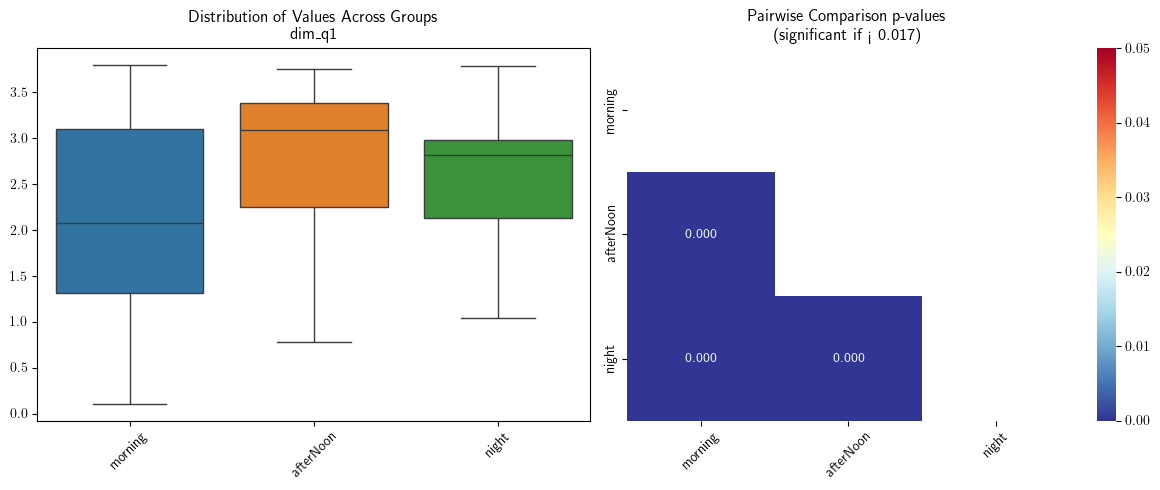


Results Interpretation for dim_q8:
Bonferroni-corrected significance level: 0.0167

Significant differences found between:
- morning vs afterNoon (p=0.0004)
- afterNoon vs night (p=0.0000)


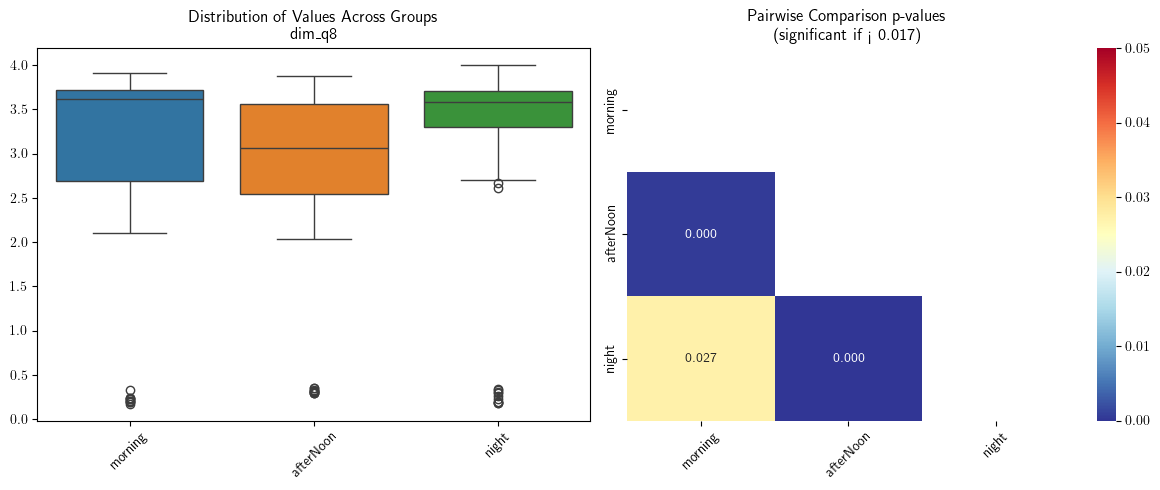


Results Interpretation for dim_q9:
Bonferroni-corrected significance level: 0.0167

Significant differences found between:
- morning vs afterNoon (p=0.0000)
- morning vs night (p=0.0000)
- afterNoon vs night (p=0.0000)


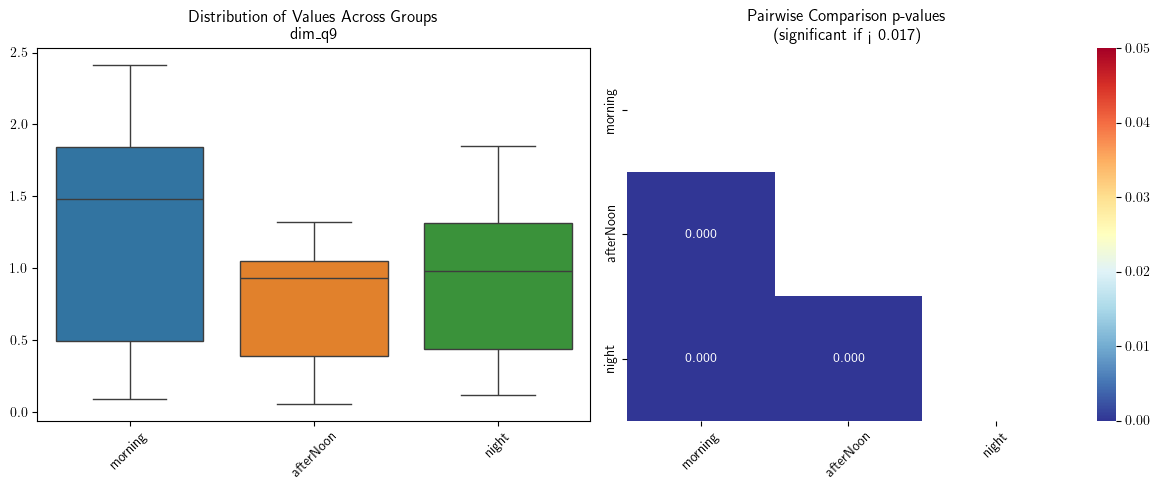

In [30]:
#all day npANOVA
#friedman

def friedman_posthoc_with_viz(df, dim_name):
    """
    Perform and visualize post-hoc analysis after significant Friedman test
    df: pandas DataFrame where columns are groups
    dim_name: name of dimension being analyzed (for plot titles)
    """
    results = {}
    
    # 1. Wilcoxon with Bonferroni correction
    groups = list(df.columns)
    n_comparisons = len(groups) * (len(groups) - 1) / 2
    alpha = 0.05
    bonferroni_alpha = alpha / n_comparisons
    
    wilcoxon_results = {}
    # Matrix to store p-values for heatmap
    p_value_matrix = np.zeros((len(groups), len(groups)))
    
    for i, j in combinations(range(len(groups)), 2):
        group1, group2 = groups[i], groups[j]
        stat, p_val = wilcoxon(df[group1], df[group2])
        wilcoxon_results[f"{group1} vs {group2}"] = {
            'statistic': stat,
            'p_value': p_val,
            'significant': p_val < bonferroni_alpha
        }
        # Fill both sides of the matrix for the heatmap
        p_value_matrix[i, j] = p_val
        p_value_matrix[j, i] = p_val
    
    results['wilcoxon'] = wilcoxon_results
    
    # Visualization
    plt.figure(figsize=(12, 5))
    
    # 1. Box plot
    plt.subplot(1, 2, 1)
    sns.boxplot(data=df)
    plt.title(f'Distribution of Values Across Groups\n{dim_name}')
    plt.xticks(rotation=45)
    
    # 2. Heatmap of p-values
    plt.subplot(1, 2, 2)
    mask = np.triu(np.ones_like(p_value_matrix, dtype=bool))  # mask upper triangle
    sns.heatmap(p_value_matrix, 
                mask=mask,
                xticklabels=groups,
                yticklabels=groups,
                annot=True,  # Show numbers
                fmt='.3f',   # Format to 3 decimal places
                cmap='RdYlBu_r',  # Red for significant, blue for non-significant
                vmin=0,
                vmax=0.05)
    plt.title('Pairwise Comparison p-values\n(significant if < {:.3f})'.format(bonferroni_alpha))
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Print interpretation
    print(f"\nResults Interpretation for {dim_name}:")
    print("=" * 50)
    print(f"Bonferroni-corrected significance level: {bonferroni_alpha:.4f}")
    print("\nSignificant differences found between:")
    significant_pairs = []
    for pair, result in wilcoxon_results.items():
        if result['significant']:
            significant_pairs.append(f"- {pair} (p={result['p_value']:.4f})")
    if significant_pairs:
        print("\n".join(significant_pairs))
    else:
        print("No significant differences found after Bonferroni correction")
    
    return results, plt.gcf()  # Return both results and figure

#end of func


npAnovaResultsAllDays = {}

for dim in dim_q:  # Iterate over dimensions
    # Initialize storage for this dimension
    npAnovaResultsAllDays[dim] = {}
    
    # Aggregate data across all days for each period
    periodAllDays = {'earlyMorning': [], 'morning': [], 'afterNoon': [], 'night': []}
    for day in dim_q[dim]:
        for period in periodAllDays.keys():
            # Collect data from all days into the corresponding period
            periodAllDays[period].extend(list(eval(period)[dim][day].values()))
    
    #Create a DataFrame for all days combined
    dfAnovaAllDays = pd.DataFrame(periodAllDays)

     # Drop columns where >50% of data is -5000
    for col in dfAnovaAllDays.columns:
        if (dfAnovaAllDays[col] == -5000).sum() > 0.5 * len(dfAnovaAllDays):
            dfAnovaAllDays.drop(columns=[col], inplace=True)
    
    # Drop rows where any value is -5000
    dfAnovaAllDays = dfAnovaAllDays[~dfAnovaAllDays.isin([-5000]).any(axis=1)]
    
    # Perform friedmann test if there are at least 2 groups (columns)
    if len(dfAnovaAllDays.columns) >= 3 and len(dfAnovaAllDays) > 2 and all(dfAnovaAllDays[col].notna().sum() > 0 for col in dfAnovaAllDays.columns) and len(set(dfAnovaAllDays[col].notna().sum() for col in dfAnovaAllDays.columns)) == 1:
        stat, pVal = friedmanchisquare(*[dfAnovaAllDays[col] for col in dfAnovaAllDays.columns])
        if pVal < 0.05:  # If Friedman test is significant
            posthoc_results, fig  = friedman_posthoc_with_viz(dfAnovaAllDays, dim)
            plt.savefig(os.path.join(mainfolder, "all_day_subjective_dim_corr_post_hoc.png"), bbox_inches='tight', dpi=300)
            plt.show()
            plt.close()

            npAnovaResultsAllDays[dim]['posthoc'] = posthoc_results
        else:
            npAnovaResultsAllDays[dim]['posthoc'] = []
        # Store results
        npAnovaResultsAllDays[dim]['stat'] = stat
        npAnovaResultsAllDays[dim]['p_val'] = pVal
        npAnovaResultsAllDays[dim]['groups'] = list(dfAnovaAllDays.columns)
        npAnovaResultsAllDays[dim]['final data length'] = len(dfAnovaAllDays)
    else:
        # Insufficient data for test
        npAnovaResultsAllDays[dim]['stat'] = None
        npAnovaResultsAllDays[dim]['p_val'] = None
        npAnovaResultsAllDays[dim]['groups'] = list(dfAnovaAllDays.columns)
        npAnovaResultsAllDays[dim]['final data length'] = len(dfAnovaAllDays)


In [26]:
npAnovaResultsAllDays

{'dim_q1': {'stat': None,
  'p_val': None,
  'groups': ['earlyMorning', 'morning', 'afterNoon', 'night'],
  'final data length': 0},
 'dim_q2': {'stat': None,
  'p_val': None,
  'groups': ['earlyMorning', 'morning', 'afterNoon', 'night'],
  'final data length': 0},
 'dim_q3': {'stat': None,
  'p_val': None,
  'groups': ['earlyMorning', 'morning', 'afterNoon', 'night'],
  'final data length': 2},
 'dim_q4': {'stat': None,
  'p_val': None,
  'groups': ['earlyMorning', 'morning', 'afterNoon', 'night'],
  'final data length': 0},
 'dim_q5': {'stat': None,
  'p_val': None,
  'groups': ['earlyMorning', 'morning', 'afterNoon', 'night'],
  'final data length': 0},
 'dim_q6': {'stat': None,
  'p_val': None,
  'groups': ['earlyMorning', 'morning', 'afterNoon', 'night'],
  'final data length': 1},
 'dim_q7': {'stat': None,
  'p_val': None,
  'groups': ['earlyMorning', 'morning', 'afterNoon', 'night'],
  'final data length': 1},
 'dim_q8': {'stat': None,
  'p_val': None,
  'groups': ['earlyMorning

In [29]:
dfAnovaAllDays

,earlyMorning,morning,afterNoon,night
0,-5000.0,-5000.000000,0.298838,-5000.000000
1,-5000.0,-5000.000000,-5000.000000,0.390033
2,-5000.0,-5000.000000,0.306210,0.398446
3,-5000.0,-5000.000000,-5000.000000,-5000.000000
4,-5000.0,-5000.000000,-5000.000000,0.398360
...,...,...,...,...
379,-5000.0,-5000.000000,0.181824,-5000.000000
380,-5000.0,0.241873,-5000.000000,-5000.000000
381,-5000.0,-5000.000000,0.197857,-5000.000000
382,-5000.0,-5000.000000,0.214570,-5000.000000
